In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import os
import mat4py
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2022-10-26 14:04:59.512906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 14:05:00.142089: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 14:05:01.153846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-26 14:05:01.153922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Autosaving every 180 seconds


In [2]:
#read in raw PCAP files from Volpe
import velodyne_decoder as vd
config = vd.Config(model="VLP-16", rpm = 600)
pcap_file = '/media/derm/06EF-127D1/volpe/2021-03-10-16-43-50_Velodyne-VLP-16-Data_garminSignage.pcap'

cloud_arrays = []
stamps = []
for stamp, points in vd.read_pcap(pcap_file, config):
    cloud_arrays.append(points)
    stamps.append(stamp)

In [3]:
from ICET_spherical import ICET
idx = 800 #frame idx
D  = True #draw scene
X = tf.constant([0., 0., 0., 0., 0., 0.]) #initial transformation estimate

#cloud_arrays ..... [5622][x, y, z, intensity, ring, time]
pc1 = cloud_arrays[idx][:,:3]
pc2 = cloud_arrays[idx+1][:,:3]

it1 = ICET(cloud1 = pc1, cloud2 = pc2,  fid = 30, draw = D, x0 = X, 
           niter = 8, group= 2, RM = True, DNN_filter = False)
ViewInteractiveWidget(it1.plt.window)


2022-10-26 14:05:16.316548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 14:05:16.318222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:05:16.318529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 14:05:16.318766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer


 estimated solution vector X: 
 tf.Tensor([0. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


2022-10-26 14:05:20.171887: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-26 14:05:20.378889: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8a9d2c30



 estimated solution vector X: 
 tf.Tensor([ 0.5616859   0.01696611  0.0175384  -0.00637113 -0.01023397  0.00181613], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor(
[ 7.3149967e-01  1.3502083e-02  1.8911861e-02  6.1217090e-04
 -1.0655732e-02  3.0921435e-03], shape=(6,), dtype=float32)

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.727038    0.01517883  0.03139077  0.00085572 -0.00780047  0.00580123], shape=(6,), dtype=float32)

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.7273984   0.01787437  0.03450479  0.00108793 -0.00700534  0.00649788], shape=(6,), dtype=float32)

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.73064035  0.01527027  0.03848632  0.00110028 -0.00652774  0.00691055], shape=(6,), dtype=float32)

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.7396141   0.01567721  0.03379235  0.00096829 -0.00669079  0.0069

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1300)

In [4]:
print(it1.X)
print(it1.pred_stds)

tf.Tensor([ 0.7390529   0.01668315  0.03126919  0.00085834 -0.00695431  0.00683919], shape=(6,), dtype=float32)
tf.Tensor([0.06025848 0.02637275 0.0744102  0.00375696 0.00543179 0.003589  ], shape=(6,), dtype=float32)


In [ ]:
from ICET_spherical import ICET

runlen = 5621
estimate_history = np.zeros([runlen,6])
pred_stds = np.zeros([runlen,6])

err_cnt = 0
X = tf.constant([0., 0., 0., 0., 0., 0.]) #initial transformation estimate

for idx in range(400, runlen):
    
    print("\n --- idx ---", idx)
    
    #cloud_arrays ..... [5622][x, y, z, intensity, ring, time]
    pc1 = cloud_arrays[idx][:,:3]
    pc2 = cloud_arrays[idx+1][:,:3]

    try:
        it = ICET(cloud1 = pc1, cloud2 = pc2,  fid = 30, draw = False, x0 = X,
                   niter = 8, group= 2, RM = True, DNN_filter = False)

        estimate_history[idx,:] = it.X
        pred_stds[idx,:] = it.pred_stds
        
#         if it.X[0] > 0:
#             X = it.X
#         else:
#             X = tf.constant([0., 0., 0., 0., 0., 0.]) #initial transformation estimate
        
    except:
        print("ICET ERROR")
        err_cnt +=1
        
save_fn = "ICET_signage_fid30"
np.save(save_fn + "_estimates", estimate_history)
np.save(save_fn + "_pred_stds", pred_stds)

v1 .... mnp=50, fid=50, x0=0

(5621, 6)
(5668, 6)
(5668,)


<IPython.core.display.Javascript object>


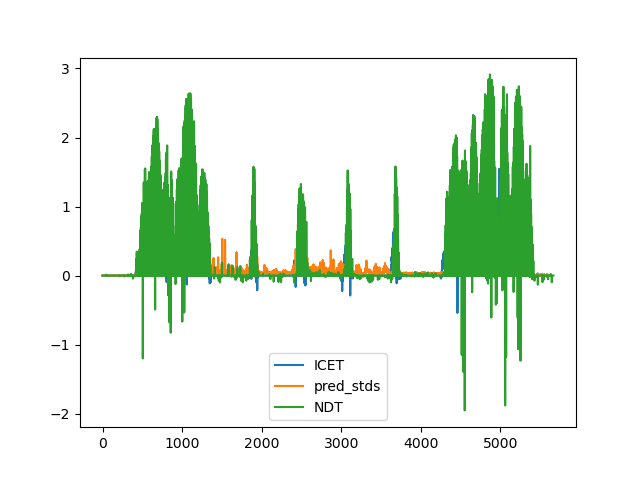

In [75]:
# estimate_history = np.load("ICET_signage_fid50_estimates.npy") 
estimate_history = np.load("ICET_signage_fid30_estimates.npy") #fid30 way better than fid50 for the 16 channel sensor
pred_stds = np.load("ICET_signage_fid30_pred_stds.npy")
# pred_stds = np.load("ICET_signage_fid50_estimates.npy") #debug
print(np.shape(estimate_history))

# # NDT keyframing every new scan ----------------------------------
# # NDT_raw = np.loadtxt("NDT_results_pt5m_signage.txt")
# NDT_raw = np.loadtxt("NDT_results_2m_signage.txt")
# # NDT_raw = np.loadtxt("NDT_results_signage.txt")
# #-----------------------------------------------------------------

# NDT dynamic keyframing -----------------------------------------
NDT_raw = np.loadtxt("NDT_results_v5d1_noRejection_signage.txt")
keyframe_idx = np.loadtxt("NDT_keyframes_v5d1_noRejection_signage.txt")[1:]
# NDT_raw = np.loadtxt("NDT_results_v2pt5d1_noRejection_signage.txt")
# keyframe_idx = np.loadtxt("NDT_keyframes_v2pt5d1_noRejection_signage.txt")[1:]

# NDT_raw = np.loadtxt("NDT_results_v2pt5d1_signage_v2.txt")
# keyframe_idx = np.loadtxt("NDT_keyframes_v2pt5d1_signage_v2.txt")[:-1]

NDT_raw = keyframe_idx[:,None]*NDT_raw
# NDT_raw[:5621,3] = -estimate_history[:,5] #DEBUG - cheat by copying rotations from ICET

print(np.shape(NDT_raw))
print(np.shape(keyframe_idx))

#-----------------------------------------------------------------


#zero out negative forward movement
# estimate_history[estimate_history[:,0] < 0, 0] = 0
# NDT_raw[NDT_raw[:,1] < 0, 1] = 0

#suppress motion in periods where vehicle is parked 
estimate_history[1360:1850] = 0
estimate_history[1950:2400] = 0
estimate_history[2550:3000] = 0
estimate_history[3150:3600] = 0
estimate_history[3750:4250] = 0


component = 0 #x
# component = 5 #yaw

fig, ax = plt.subplots()
ax.plot(estimate_history[:,component], label = "ICET")
ax.plot(pred_stds[:,component], label = "pred_stds")
vf = np.sqrt(estimate_history[:,0]**2 + estimate_history[:,1]**2)
# ax.plot(vf, label = "total vf ICET")
ax.plot(NDT_raw[:,1], label = "NDT")
ax.legend(loc = "best")
# ax.plot(np.diff(gps, axis = 0)[:,1])


# Plot East/ North trajectory of ground truth, NDT, and ICET

(2851, 7)


<IPython.core.display.Javascript object>


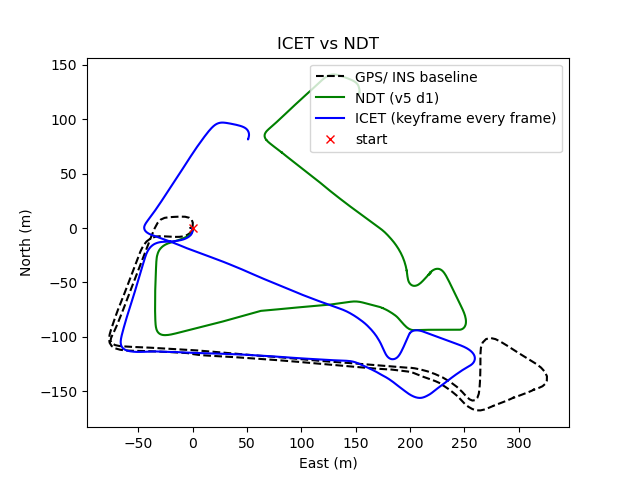

In [76]:
#load MatLab files
cwd = os.getcwd()
vp = os.path.dirname(os.path.realpath(cwd)) + "/volpe/" #Volpe Path

gtfn = vp + "gps_enu.mat"
gt = np.transpose(mat4py.loadmat(gtfn)['gps_enu']) 

NDTfn = vp + "pos_lidar_enu.mat"
NDT = np.asarray(mat4py.loadmat(NDTfn)['pos_lidar_enu'])
print(np.shape(NDT))

# -----------------------------------------------
# print(np.shape(estimate_history))
ICET_total = np.zeros(np.shape(estimate_history))
NDT_total = np.zeros(np.shape(NDT_raw))
for i in range(np.shape(estimate_history)[0]):
    ICET_total[i] = np.sum(estimate_history[:i], axis = 0)
    NDT_total[i] = np.sum(NDT_raw[:i], axis = 0)

ICET_total[:,5] += np.deg2rad(90) #set initial rotation
NDT_total[:,5] += np.deg2rad(90)
    
#need to combine TOTAL heading with incremental changes in x and y (really should be ignoring y...)
ICET_traj = np.zeros([np.shape(estimate_history)[0], 2])
NDT_traj = np.zeros([np.shape(estimate_history)[0], 2])

for j in range(1, np.shape(estimate_history)[0]):
    #x[i] = x[i-1] + step_dist*cos(heading)z
    ICET_traj[j,0] = ICET_traj[j-1,0] +estimate_history[j,0]*np.cos(ICET_total[j,5])
#     ICET_traj[j,0] = ICET_traj[j-1,0] + vf[j]*np.cos(ICET_total[j,5])
    NDT_traj[j,0] = NDT_traj[j-1,0] + NDT_raw[j,1]*np.cos(-NDT_total[j,3])

    #y[i] = y[i-1] + step_dist*sin(heading)
    ICET_traj[j,1] = ICET_traj[j-1,1] + estimate_history[j,0]*np.sin(ICET_total[j,5])
#     ICET_traj[j,1] = ICET_traj[j-1,1] + vf[j]*np.sin(ICET_total[j,5])
    NDT_traj[j,1] = NDT_traj[j-1,1] + NDT_raw[j,1]*np.sin(-NDT_total[j,3])
# -----------------------------------------------

#plot xy total positions
fig, ax = plt.subplots(1,1)
ax.set_aspect('equal')
ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.set_title("ICET vs NDT")

font = {'fontname':'Times New Roman'}
ax.plot(gt[:,0], gt[:,1], 'k--', label = "GPS/ INS baseline")
# ax.plot(NDT[:,0], NDT[:,1], label = "NDT (Tuned)") #using pre-made NDT trajectory
ax.plot(NDT_traj[:,1], -NDT_traj[:,0], 'g', label = "NDT (v5 d1)") #debug NDT trajectory inherited from MatLab code"
ax.plot(-ICET_traj[:,0], -ICET_traj[:,1], 'b', label = "ICET (keyframe every frame)")
ax.plot(0, 'rx', label = "start")
ax.legend(loc = 'best')

In [77]:
# interpolate GPS ground truth to lidar time basis
import mat4py
# gps = np.array(mat4py.loadmat("/home/derm/ASAR/volpe/gps_enu.mat")['gps_enu'])
# lidartime = np.array(mat4py.loadmat("/home/derm/ASAR/volpe/lidar_time.mat")['t'])
lidartime = np.array(stamps)[:-1]
print(lidartime)

gps = np.loadtxt("gps_pos_enu_lidartime.txt")

#make gps and lidar both start at t=0
gps[:,0] = gps[:,0] - gps[0,0]
lidartime -= lidartime[0]

# fig, ax = plt.subplots()
# ax.set_xlabel("frame")
# ax.set_ylabel("timestamp")

# ax.plot(gps[:,0], label = 'gps time')
# ax.plot(lidartime, label = 'lidar time')
# ax.legend(loc = 'best')

# print(gps)

[1.61541264e+09 1.61541264e+09 1.61541264e+09 ... 1.61541321e+09
 1.61541321e+09 1.61541321e+09]


<IPython.core.display.Javascript object>


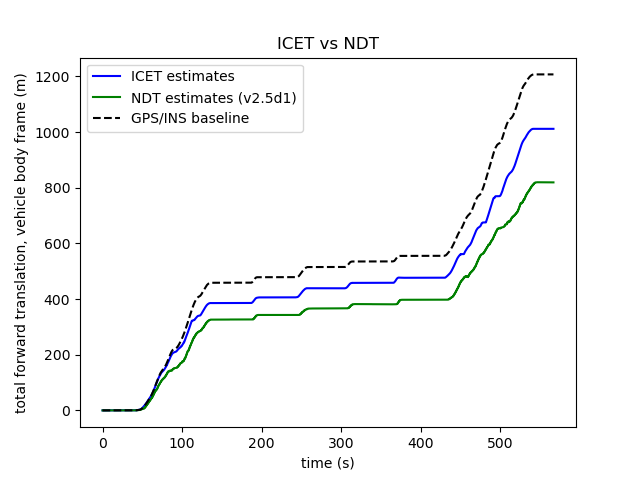

[[0.05946036 0.05946036 0.11892071 0.0005946  0.0005946  0.00118921]
 [0.05954664 0.05978513 0.11892162 0.00215906 0.00163373 0.00123998]
 [0.0596212  0.06012054 0.11892219 0.00302519 0.00215772 0.0012841 ]
 [0.05972242 0.06044702 0.11892312 0.00383144 0.00269429 0.00132963]
 [0.0611698  0.06113899 0.12875067 0.00449305 0.0034621  0.0014386 ]]
[[0.00320438 0.00622313 0.00046552 0.00207557 0.00152169 0.00035119]
 [0.00298085 0.00634179 0.00036874 0.00211901 0.00140949 0.00033369]
 [0.0034756  0.00627393 0.00046977 0.00235121 0.00161352 0.00034497]
 [0.0132279  0.00917249 0.04933585 0.00234681 0.00217414 0.00054924]
 [0.01134454 0.00627682 0.00114529 0.00199851 0.00165276 0.00033643]]


In [80]:
#plot total forward translation of ICET with error bounds

fig, ax = plt.subplots()
ax.set_xlabel("time (s)")
ax.set_ylabel("total forward translation, vehicle body frame (m)")
ax.set_title("ICET vs NDT")
ax.plot(lidartime, ICET_total[:,0], label = "ICET estimates", color = 'blue')
ax.plot(lidartime, NDT_total[:5621,1], label = "NDT estimates (v2.5d1)", color = 'green')

#--------------------------------------------------
# get cumulative ICET error bounds
cum_err = np.zeros(np.shape(pred_stds))
for i in range(np.shape(pred_stds)[0]):
    cum_err[i,:] = np.sum(pred_stds[:i,:]**2, axis = 0)
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2#add in baseline OXTS 1-sigma errors
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
#--------------------------------------------------

frame = 400
print(cum_err[frame:frame+5])
print(pred_stds[frame:frame+5])

gps_cum = np.zeros(np.shape(gps)[0])
dgps = abs(np.diff(gps, axis = 0))
dgps_fwd = np.sqrt(dgps[:,1]**2 + dgps[:,2]**2)
for i in range(np.shape(gps)[0]):
    gps_cum[i] = np.sum(dgps_fwd[:i], axis = 0)

    
#interpolate gps_cum
gps_time = gps[:,0]
gps_cum_lidartime = np.interp(lidartime, gps_time, gps_cum) #(newtime, oldtime, oldpos)
# gps_time = range(27, np.shape(gps_cum)[0]+27) #for debug
# ax.plot(gps_time, gps_cum, 'k--', label = "GPS/INS baseline") #for debug
ax.plot(lidartime, gps_cum_lidartime, 'k--', label = "GPS/INS baseline")
# ax.fill_between(lidartime, gps_cum_lidartime -2*cum_err[:,1], gps_cum_lidartime + 2*cum_err[:,1], 
#              color = (0,0,1,0.2), label = 'Predicted 2σ Error Bounds')
ax.legend(loc = 'best')

<IPython.core.display.Javascript object>


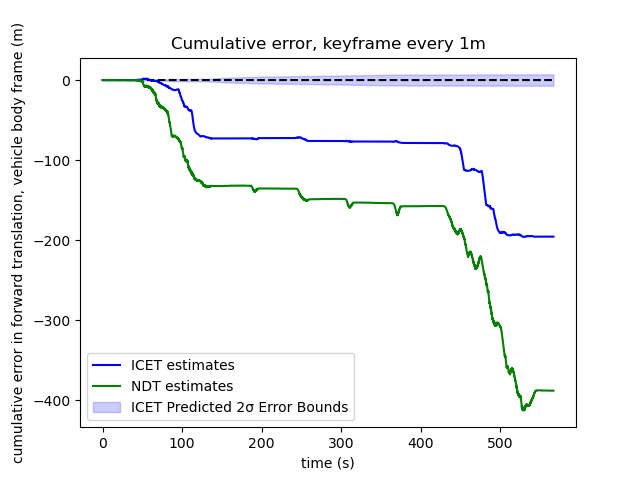

In [81]:
#plot total error in forward translation for each method

fig, ax = plt.subplots()
ax.plot(lidartime, gps_cum_lidartime*0, 'k--' ) #zero baseline
ax.set_xlabel("time (s)")

#cumulative
ax.plot(lidartime,  ICET_total[:,0] - gps_cum_lidartime, label = "ICET estimates", color = 'blue')
ax.plot(lidartime,  NDT_total[:5621,1] - gps_cum_lidartime, label = "NDT estimates", color = 'green')
ax.fill_between(lidartime, -2*cum_err[:,1], 2*cum_err[:,1], 
             color = (0,0,1,0.2), label = 'ICET Predicted 2σ Error Bounds')
ax.set_ylabel("cumulative error in forward translation, vehicle body frame (m)")
ax.set_title("Cumulative error, keyframe every 1m")

#per frame
# ax.plot(lidartime[:-1], np.diff(gps_cum_lidartime - ICET_total[:,0]), label = "ICET estimates", color = 'blue')
# ax.plot(lidartime[:-1], np.diff(gps_cum_lidartime - NDT_total[:5621,1]), label = "NDT estimates", color = 'green')
# ax.fill_between(lidartime, -2*pred_stds[:,0], 2*pred_stds[:,0], 
#                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# ax.set_ylabel("per-frame error in forward translation, vehicle body frame (m)")
# ax.set_title("per-frame error, keyframe every frame")


ax.legend(loc='best')

In [10]:
#TEST- load liar velocity estimated by Volpe
import pandas as pd
from scipy.spatial.transform import Rotation

volpe_lidar_raw = vp + "relPos_lidar.mat"
NDT_raw = np.asarray(mat4py.loadmat(volpe_lidar_raw)['relPos_lidar'])#[:,:3]
NDT_trans = NDT_raw[:,:3]

#not sure why this file is half the length of the full rel pos...
# volpe_lidar_raw_rot = vp + "yaw_lidar.mat"
# NDT_rot = np.asarray(mat4py.loadmat(volpe_lidar_raw_rot)['yaw_lidar'])
# print(np.shape(NDT_rot))

rot = Rotation.from_quat(NDT_raw[1:,3:])
rot_euler = rot.as_euler('xyz', degrees=True)
NDT_rot = pd.DataFrame(data=rot_euler, columns=['x', 'y', 'z']).to_numpy()

print(np.shape(NDT_trans))
print(np.shape(NDT_rot))

print(NDT_trans[2500])

(5670, 3)
(5669, 3)
[-0.03935342  0.36233065  0.00870829]
